<a href="https://colab.research.google.com/github/VishnuPrabhakaran0076/assessment-usecase1-2/blob/main/Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pyspark textblob


In [ ]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.types import (
    StructType, StructField, StringType,
    IntegerType, TimestampType
)
from pyspark.sql.functions import col, to_timestamp, udf, count, avg
from pyspark.sql import functions as F
import datetime
import random
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("CustomerFeedbackAnalysis") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# Define schema for feedback data
feedback_schema = StructType([
    StructField("Customer_ID", StringType(), False),
    StructField("Feedback_Channel", StringType(), False),
    StructField("Rating", IntegerType(), False),
    StructField("Comment", StringType(), True),
    StructField("Date", TimestampType(), False)
])

In [ ]:
def generate_spark_data(num_records=1000):
    """Generate sample data in Spark"""
    channels = ["Email", "Social Media", "Survey","Live chat","Interview"]
    comments = ["Too many bugs in the app....", "Too many ads on the platform....", "Love the new updates!", "Fantastic i love it !", "Horrible service to slow!", "Will be recommend !","I faced issues with payment.","Product is overpriced.","I received wrong item."]

    data = []
    current_date = datetime.datetime.now()

    for _ in range(num_records):
        data.append((
            f"C{random.randint(10000, 99999)}",
            random.choice(channels),
            random.randint(1, 5),
            random.choice(comments),
            (current_date - datetime.timedelta(days=random.randint(0, 30)))
        ))

    # Create Spark DataFrame
    return spark.createDataFrame(data, ["Customer_ID", "Feedback_Channel", "Rating", "Comment", "Date"])

# Generate the Spark DataFrame
spark_df = generate_spark_data(1000)
spark_df.show(5)


+-----------+----------------+------+--------------------+--------------------+
|Customer_ID|Feedback_Channel|Rating|             Comment|                Date|
+-----------+----------------+------+--------------------+--------------------+
|     C68658|       Live chat|     3|I received wrong ...|2024-10-21 11:15:...|
|     C68223|       Live chat|     5|Fantastic i love ...|2024-10-12 11:15:...|
|     C88257|           Email|     2|Too many ads on t...|2024-10-21 11:15:...|
|     C85608|    Social Media|     4|Horrible service ...|2024-11-04 11:15:...|
|     C43146|           Email|     4|Horrible service ...|2024-10-28 11:15:...|
+-----------+----------------+------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
def spark_to_pandas(spark_df):
    """Convert Spark DataFrame to Pandas DataFrame"""
    try:
        pandas_df = spark_df.toPandas()
        print(f"Successfully converted {len(pandas_df)} records to pandas DataFrame")
        return pandas_df
    except Exception as e:
        print(f"Error converting to pandas: {e}")
        return None

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = spark_to_pandas(spark_df.limit(1000))
print(pandas_df.head())

Successfully converted 1000 records to pandas DataFrame
  Customer_ID Feedback_Channel  Rating                           Comment  \
0      C68658        Live chat       3            I received wrong item.   
1      C68223        Live chat       5             Fantastic i love it !   
2      C88257            Email       2  Too many ads on the platform....   
3      C85608     Social Media       4         Horrible service to slow!   
4      C43146            Email       4         Horrible service to slow!   

                        Date  
0 2024-10-21 11:15:56.856753  
1 2024-10-12 11:15:56.856753  
2 2024-10-21 11:15:56.856753  
3 2024-11-04 11:15:56.856753  
4 2024-10-28 11:15:56.856753  


In [ ]:
def clean_data(df):
    """Clean the feedback comments"""
    # Remove unnecessary characters and handle missing values
    df['Comment'] = df['Comment'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.strip()
    df['Comment'] = df['Comment'].fillna('No Comment')
    return df

# Clean the data
pandas_df = clean_data(pandas_df)


In [ ]:

def analyze_sentiment(comment):
    """Analyze sentiment of the comment"""
    analysis = TextBlob(comment)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Perform sentiment analysis
sentiment_udf = udf(analyze_sentiment, StringType())
spark_df = spark_df.withColumn("Sentiment", sentiment_udf(col("Comment")))


In [ ]:
def perform_analysis(pandas_df):
    """Perform basic analysis on the pandas DataFrame"""
    if pandas_df is None:
        print("No data available for analysis")
        return None

    analysis = {
        'total_records': len(pandas_df),
        'channel_distribution': pandas_df['Feedback_Channel'].value_counts().to_dict(),
        'average_rating': pandas_df['Rating'].mean(),
        'rating_distribution': pandas_df['Rating'].value_counts().sort_index().to_dict()
    }

    return analysis

# Perform analysis on the processed Pandas DataFrame
analysis = perform_analysis(pandas_df)
if analysis:
    print("\nAnalysis Results:")
    for key, value in analysis.items():
        print(f"{key}: {value}")




Analysis Results:
total_records: 1000
channel_distribution: {'Social Media': 216, 'Interview': 202, 'Survey': 202, 'Email': 195, 'Live chat': 185}
average_rating: 2.944
rating_distribution: {1: 212, 2: 209, 3: 204, 4: 173, 5: 202}


In [ ]:

# Trend analysis
def trend_analysis(spark_df):
    """Analyze trends over time and by channel"""
    # Convert date to date format
    spark_df = spark_df.withColumn("Date", to_timestamp(col("Date")))

    # Average ratings per channel
    avg_rating_per_channel = spark_df.groupBy("Feedback_Channel").agg(avg("Rating").alias("Average_Rating"))
    avg_rating_per_channel.show()

    # Count of sentiments by channel
    sentiment_distribution = spark_df.groupBy("Feedback_Channel", "Sentiment").agg(count("Sentiment").alias("Count"))
    sentiment_distribution.show()

    # Generate plots
    return avg_rating_per_channel, sentiment_distribution

avg_rating_per_channel, sentiment_distribution = trend_analysis(spark_df)


+----------------+------------------+
|Feedback_Channel|    Average_Rating|
+----------------+------------------+
|           Email| 3.158974358974359|
|    Social Media| 2.962962962962963|
|       Live chat|3.0108108108108107|
|       Interview|2.8465346534653464|
|          Survey|2.7524752475247523|
+----------------+------------------+

+----------------+---------+-----+
|Feedback_Channel|Sentiment|Count|
+----------------+---------+-----+
|       Live chat| Negative|   55|
|    Social Media| Negative|   51|
|           Email|  Neutral|   62|
|    Social Media|  Neutral|   62|
|       Live chat|  Neutral|   53|
|           Email| Positive|   88|
|          Survey| Positive|  100|
|       Interview|  Neutral|   60|
|       Interview| Positive|   97|
|    Social Media| Positive|  103|
|          Survey| Negative|   37|
|       Live chat| Positive|   77|
|       Interview| Negative|   45|
|           Email| Negative|   45|
|          Survey|  Neutral|   65|
+----------------+---------

In [16]:
def visualize_sentiment_distribution(sentiment_distribution):
    """Visualize sentiment distribution as pie charts by feedback channel."""
    sentiment_pd = sentiment_distribution.toPandas()

    # Set up grid layout for pie charts (one per feedback channel)
    channels = sentiment_pd['Feedback_Channel'].unique()
    num_channels = len(channels)
    fig, axes = plt.subplots(1, num_channels, figsize=(15, 6), subplot_kw=dict(aspect="equal"))

    for i, channel in enumerate(channels):
        # Data for current channel
        channel_data = sentiment_pd[sentiment_pd['Feedback_Channel'] == channel]

        # Pie chart
        axes[i].pie(channel_data['Count'], labels=channel_data['Sentiment'], autopct='%1.1f%%', startangle=140)
        axes[i].set_title(channel)

    plt.suptitle('Sentiment Distribution by Feedback Channel')
    plt.show()


In [17]:
def visualize_average_ratings(avg_rating_per_channel):
    """Visualize average ratings by feedback channel using a horizontal bar chart."""
    avg_rating_pd = avg_rating_per_channel.toPandas()

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(y='Feedback_Channel', x='Average_Rating', data=avg_rating_pd, orient='h', palette='coolwarm')
    plt.title('Average Ratings by Feedback Channel')
    plt.xlabel('Average Rating')
    plt.ylabel('Feedback Channel')
    plt.xlim(0, 5)  # Set x-axis limit
    plt.show()


In [18]:
def visualize_trends_over_time(spark_df):
    """Visualize feedback trends over time with monthly aggregation."""
    trend_data = (spark_df
                  .groupBy(F.date_trunc("month", col("Date")).alias("Month"))
                  .agg(F.count("Customer_ID").alias("Feedback_Count")))
    trend_data_pd = trend_data.orderBy("Month").toPandas()

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=trend_data_pd, x='Month', y='Feedback_Count', marker='o', color='skyblue')
    plt.fill_between(trend_data_pd['Month'], trend_data_pd['Feedback_Count'], color="skyblue", alpha=0.4)
    plt.title('Monthly Feedback Trends Over Time')
    plt.ylabel('Number of Feedbacks')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    plt.show()



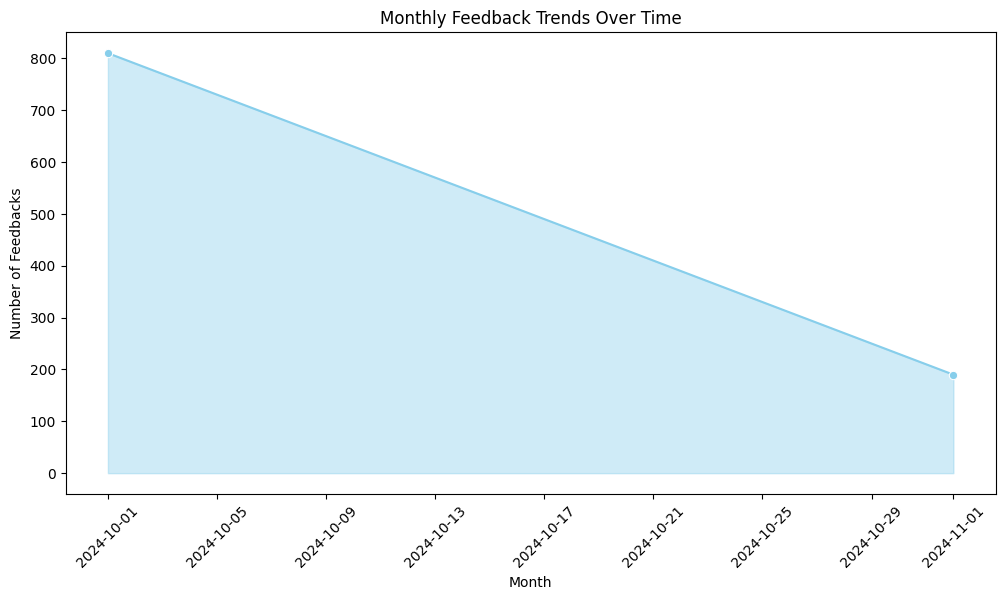

In [19]:
visualize_trends_over_time(spark_df)


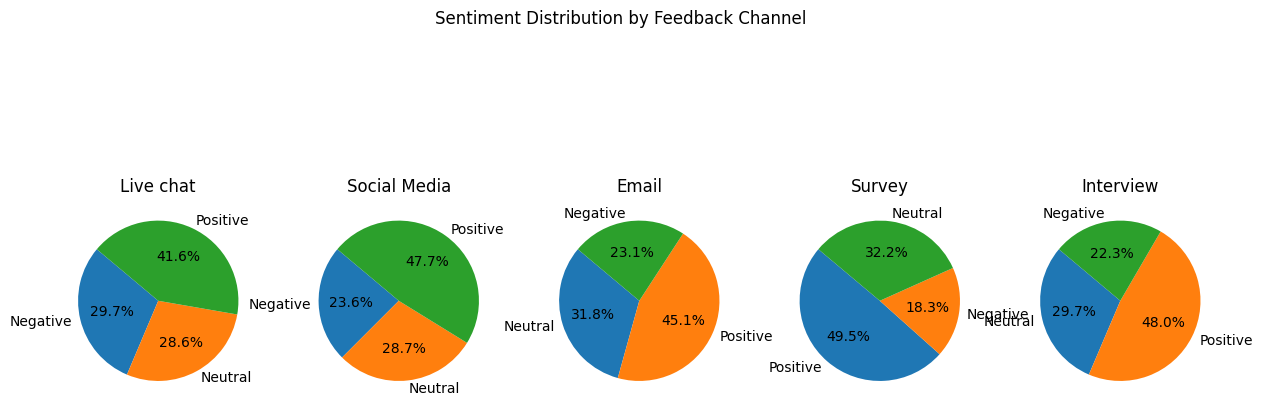

In [20]:

visualize_sentiment_distribution(sentiment_distribution)


<ipython-input-17-9deff4c382e7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Feedback_Channel', x='Average_Rating', data=avg_rating_pd, orient='h', palette='coolwarm')


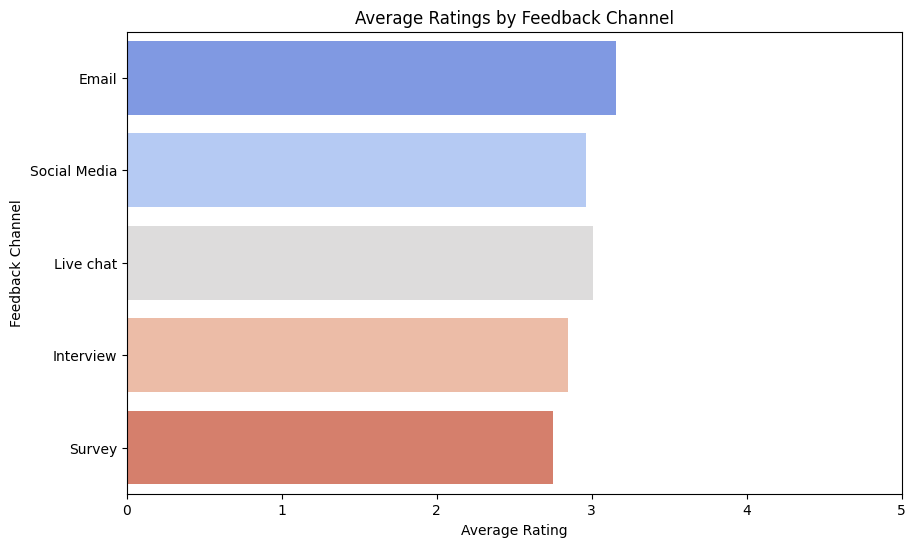

In [21]:
visualize_average_ratings(avg_rating_per_channel)

In [22]:
def visualize_average_ratings_as_pie(avg_rating_per_channel):
    """
    Visualize average ratings by feedback channel as a pie chart with enhanced visuals.

    Parameters:
    - avg_rating_per_channel: Spark DataFrame with average ratings per channel.
    """
    # Convert Spark DataFrame to Pandas DataFrame for plotting
    avg_rating_pd = avg_rating_per_channel.toPandas()

    # Calculate the percentage contribution of each channel’s average rating
    avg_rating_pd['Percentage'] = (avg_rating_pd['Average_Rating'] / avg_rating_pd['Average_Rating'].sum()) * 100

    # Define colors and explode effect
    colors = sns.color_palette("pastel")[0:len(avg_rating_pd)]
    explode = [0.05] * len(avg_rating_pd)  # Slightly separate each slice

    # Create the pie chart
    plt.figure(figsize=(10, 8))
    wedges, texts, autotexts = plt.pie(
        avg_rating_pd['Percentage'],
        labels=avg_rating_pd['Feedback_Channel'],
        autopct=lambda pct: f"{pct:.1f}%\n({(pct/100) * avg_rating_pd['Average_Rating'].sum():.2f})",  # Display percentage and actual rating
        startangle=140,
        colors=colors,
        explode=explode,
        shadow=True
    )

    # Customize text properties
    for text in autotexts:
        text.set_color('black')
        text.set_fontsize(10)
    for text in texts:
        text.set_fontsize(12)

    # Add title and legend
    plt.title('Average Ratings by Feedback Channel (Percentage)', fontsize=16)
    plt.legend(wedges, avg_rating_pd['Feedback_Channel'], title="Channels", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # Show the plot
    plt.tight_layout()
    plt.show()


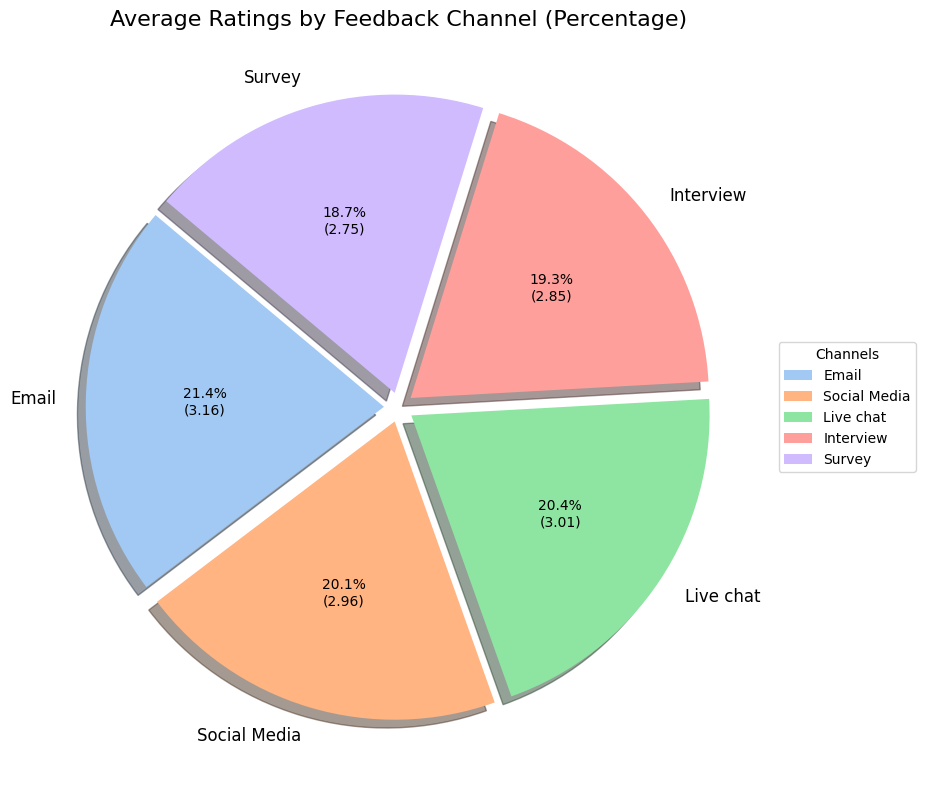

In [23]:
visualize_average_ratings_as_pie(avg_rating_per_channel)